# **0. Kaggle 데이터 연결**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bonecar","key":"16e8cf29f7ed598055d79be78b65be57"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection

Dataset URL: https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
License(s): CC0-1.0
 95% 27.0M/28.4M [00:01<00:00, 28.5MB/s]
100% 28.4M/28.4M [00:01<00:00, 19.1MB/s]


In [4]:
!unzip -o /content/fruit-images-for-object-detection.zip -d /content/data

Archive:  /content/fruit-images-for-object-detection.zip
  inflating: /content/data/test_zip/test/apple_77.jpg  
  inflating: /content/data/test_zip/test/apple_77.xml  
  inflating: /content/data/test_zip/test/apple_78.jpg  
  inflating: /content/data/test_zip/test/apple_78.xml  
  inflating: /content/data/test_zip/test/apple_79.jpg  
  inflating: /content/data/test_zip/test/apple_79.xml  
  inflating: /content/data/test_zip/test/apple_80.jpg  
  inflating: /content/data/test_zip/test/apple_80.xml  
  inflating: /content/data/test_zip/test/apple_81.jpg  
  inflating: /content/data/test_zip/test/apple_81.xml  
  inflating: /content/data/test_zip/test/apple_82.jpg  
  inflating: /content/data/test_zip/test/apple_82.xml  
  inflating: /content/data/test_zip/test/apple_83.jpg  
  inflating: /content/data/test_zip/test/apple_83.xml  
  inflating: /content/data/test_zip/test/apple_84.jpg  
  inflating: /content/data/test_zip/test/apple_84.xml  
  inflating: /content/data/test_zip/test/apple_

# **1. Import Libraries**

In [5]:
# Importing modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(1)

# **2. Processing Data**

* 이전 코드 필사에서 기존 코드의 성능이 좋지 않았음. 그래서 모델의 성능을 개선하기 위해 데이터 증강 코드를 적용해 보고자 함.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split

# Paths to training and testing data
train_path = '/content/data/train_zip/train'
test_path = '/content/data/test_zip/test'

# Shape for resizing images
shape = (200, 200)

# Data augmentation and preprocessing
# Define the ImageDataGenerator with augmentation options
data_gen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=45,      # Rotate images up to 45 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20%
    height_shift_range=0.2, # Shift images vertically by up to 20%
    shear_range=0.2,        # Shear images up to 0.2 radians
    zoom_range=0.2,         # Zoom images up to 20%
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill empty areas after transformation
)

# Function to load and preprocess images with data augmentation
def load_images_with_augmentation(path, data_gen, shape):
    images = []
    labels = []

    for filename in os.listdir(path):
        if filename.endswith('.jpg'):
            # Load image
            img = cv2.imread(os.path.join(path, filename))
            label = filename.split('_')[0]  # Extract label from filename

            # Resize image
            img = cv2.resize(img, shape)

            # Apply data augmentation
            img = img.reshape((1,) + img.shape)  # Reshape for data_gen
            augmented_images = next(data_gen.flow(img, batch_size=1))  # Generate augmented image

            images.append(augmented_images[0])  # Add augmented image to list
            labels.append(label)

    return np.array(images), pd.get_dummies(labels).values

# Load and augment training data
train_images, train_labels = load_images_with_augmentation(train_path, data_gen, shape)

# Load and augment testing data (without shuffling)
test_images, test_labels = load_images_with_augmentation(test_path, data_gen, shape)

# Split training data into training and validation sets
X_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=1)

print("Training data shape:", X_train.shape)
print("Validation data shape:", x_val.shape)
print("Testing data shape:", test_images.shape)

Training data shape: (180, 200, 200, 3)
Validation data shape: (60, 200, 200, 3)
Testing data shape: (60, 200, 200, 3)


# **3. Visualizing Data**

[False False  True False]


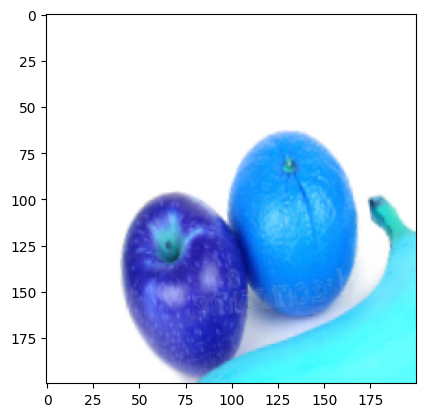

In [7]:
# Visualizing Training Data
print(train_labels[0])
plt.imshow(train_images[0])

[False  True False False]


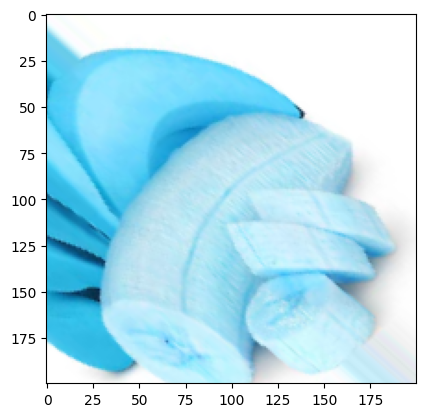

In [8]:
# Visualizing Training Data
print(train_labels[5])
plt.imshow(train_images[5])

## **4. Training Model**

In [9]:
# Creating a Sequential model
model = Sequential()
model.add(Conv2D(kernel_size=(3,3), filters = 32, activation='relu', input_shape = (200,200,3)))
model.add(Conv2D(filters=30, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(filters=30, kernel_size = (3,3), activation = 'relu'))

model.add(Flatten())

model.add(Dense(20, activation = 'relu'))
model.add(Dense(15, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))

model.compile(loss = 'categorical_crossentropy',
              metrics=['acc'],
              optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 196, 196, 30)        │           8,670 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 98, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 96, 96, 30)          │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 46, 46, 30)          │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 63480)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │       1,269,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             315 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              64 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,295,825 (4.94 MB)

 Trainable params: 1,295,825 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size = 50, validation_data=(x_val,y_val))

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - acc: 0.2278 - loss: 7.6661 - val_acc: 0.2167 - val_loss: 5.1703
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - acc: 0.3351 - loss: 5.9789 - val_acc: 0.2167 - val_loss: 5.0932
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - acc: 0.3698 - loss: 5.4242 - val_acc: 0.4167 - val_loss: 5.0338
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - acc: 0.2676 - loss: 5.8062 - val_acc: 0.4000 - val_loss: 5.0360
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - acc: 0.3224 - loss: 5.5773 - val_acc: 0.2167 - val_loss: 5.0254
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - acc: 0.3578 - loss: 5.3070 - val_acc: 0.2167 - val_loss: 5.0375
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - acc: 0.3816 - loss: 6.0557 - val_acc: 0.5000 - val_loss: 4.9896
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - acc: 0.5480 - loss: 5.9541 - val_acc: 0.4667 - val_loss: 5.1187
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - acc: 0.5444 - loss: 5.5939 -

* 데이터 증강을 통해서도 모델의 성능을 개선하기 어려웠음. 그리고 이전과 마찬가지로 loss가 nan으로 나타남.
* 데이터 증강 이외의 방법을 통해서 모델 성능 개선할 방법에 대한 고민이 필요함.

# **모델 재구성**

# **1. Processing Data**

In [12]:
# Processing training data
# -> appending images in a list 'train_images'
# -> appending labels in a list 'train_labels'

train_images = []
train_labels = []
shape = (200,200)
train_path = '/content/data/train_zip/train'

for filename in os.listdir('/content/data/train_zip/train'):
    if filename.split('.')[1] == 'jpg':
        img = cv2.imread(os.path.join(train_path, filename))
        ## numpy array 형식 (height, width, 3)

        # Spliting file names and storing the labels for image in list
        train_labels.append(filename.split('_')[0])

        # Resize all images to a specific shape
        img = cv2.resize(img,shape) ## numpy array 형식 (200,200,3)으로 변환됨

        train_images.append(img)

# Converting labels into One Hot encoded sparse matrix
train_labels = pd.get_dummies(train_labels).values

# Converting train_images to array
train_images = np.array(train_images)
## 리스트의 형식을 array로 변환하여 딥러닝에 맞도록 변환
## 4차원의 형태 (num_images, 200,200,3)

# Splitting Training data into train and validation dataset
X_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, random_state = 1)

In [13]:
# Processing testing data
# -> appending images in a list 'test_images'
# -> appneding labels in a list 'test_labels'
# The test data contains labels as well also we are appending it to a list but we aren't going to use it while training

test_images = []
test_labels = []
shape = (200,200)
test_path = '/content/data/test_zip/test'

for filename in os.listdir('/content/data/test_zip/test'):
    if filename.split('.')[1] == 'jpg':
        img = cv2.imread(os.path.join(test_path, filename))

        # Spliting file names and storing the labels for image in list
        test_labels.append(filename.split('_')[0])

        # Resize all images to a specific shape
        img = cv2.resize(img, shape)

        test_images.append(img)

# Converting test_images to array
test_images = np.array(test_images)
## 리스트의 형식을 array로 변환하여 딥러닝에 맞도록 변환
## 4차원의 형태 (num_images, 200,200,3)

# **2. Visualizing Data**

[False False  True False]


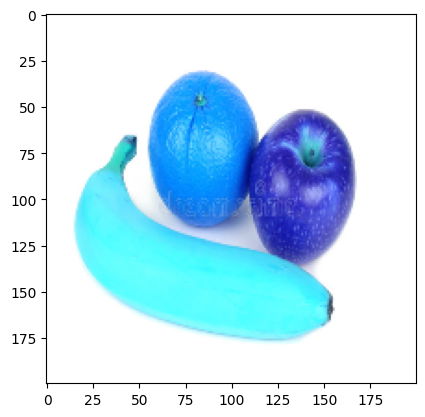

In [14]:
# Visualizing Training Data
print(train_labels[0])
plt.imshow(train_images[0])

[False  True False False]


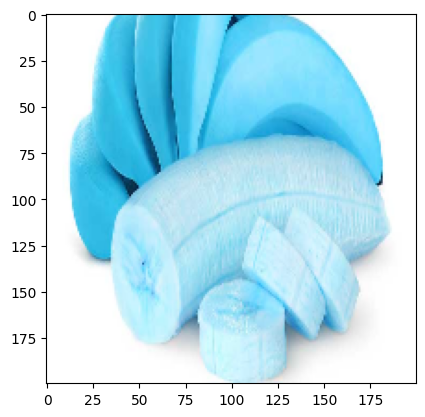

In [15]:
# Visualizing Training Data
print(train_labels[5])
plt.imshow(train_images[5])

## **3. Training Model**

적용 사항 및 기대 효과 (w/ GPT)

1.	정규화: 데이터 분포를 안정화하여 학습 안정성 증가.
2.	LeakyReLU와 초기화 변경: 기울기 소실/폭발 문제 완화.
3.	Gradient Clipping: loss 값의 NaN 발생 방지.
4.	학습률 스케줄링: 적응형 학습률로 학습 안정성 확보.
5.	Batch Normalization: 출력 분포를 안정화하여 학습 과정 개선.

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import HeNormal

# Model Definition
model = Sequential([
    Flatten(input_shape=(200, 200, 3)),
    Dense(128, kernel_initializer=HeNormal()),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dense(64, kernel_initializer=HeNormal()),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

# Optimizer with Gradient Clipping
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Model Training
history=model.fit(X_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=[reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.4748 - loss: 1.3313 - val_accuracy: 0.4000 - val_loss: 22.2518 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7706 - loss: 0.7178 - val_accuracy: 0.4833 - val_loss: 5.9414 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8583 - loss: 0.4870 - val_accuracy: 0.4667 - val_loss: 5.0449 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8617 - loss: 0.4273 - val_accuracy: 0.4333 - val_loss: 4.6803 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9053 - loss: 0.3722 - val_accuracy: 0.3833 - val_loss: 5.0923 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9293 - loss: 0.3352 - val_accuracy: 0.3833 - val_loss: 4.5557 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9065 - loss: 0.3247 - val_accuracy: 0.3833 - val_los

In [20]:
# Evaluate model on validation data
evaluate = model.evaluate(x_val, y_val)
print(evaluate)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6854 - loss: 0.9485 
[0.9528724551200867, 0.699999988079071]


In [21]:
# Testing predictions and the actual label
checkImage = test_images[0:1]
checklabel = test_labels[0:1]

predict = model.predict(np.array(checkImage))

output = {0:'apple', 1:'banana', 2:'miexd', 3:'orange'}

print("Actual: ", checklabel)
print("Predicted: ", output[np.argmax(predict)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Actual:  ['orange']
Predicted:  orange


# **모델 세부 검증**

* 위의 사항들을 이용해서 모델의 성능을 개선하였으나, 각각의 효과에 대해 검증해보기 위해 아래의 코드를 실행하여 확인하기로 함.

## **1. Training Model**

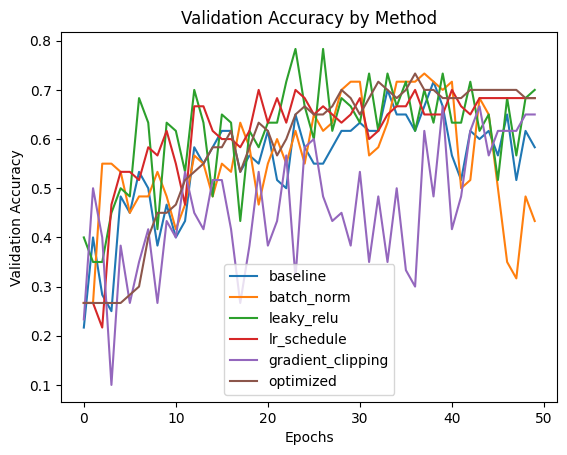

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import HeNormal
import matplotlib.pyplot as plt

# Function to train and evaluate the model
def train_model(apply_bn=False, apply_lr_schedule=False, apply_leaky_relu=False, apply_gradient_clipping=False):
    # Build model
    model = Sequential([Flatten(input_shape=(200, 200, 3))])

    model.add(Dense(128, kernel_initializer=HeNormal()))
    if apply_bn:
        model.add(BatchNormalization())
    if apply_leaky_relu:
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Dense(128, activation='relu'))

    model.add(Dense(64, kernel_initializer=HeNormal()))
    if apply_bn:
        model.add(BatchNormalization())
    if apply_leaky_relu:
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(Dense(64, activation='relu'))

    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

    # Define optimizer
    if apply_gradient_clipping:
        optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
    else:
        optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    callbacks = []
    if apply_lr_schedule:
        callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001))

    # Train model
    history = model.fit(X_train, y_train, validation_data=(x_val, y_val), epochs=50, callbacks=callbacks, verbose=0)

    return history

# Train and evaluate models with different settings
results = {
    'baseline': train_model(),
    'batch_norm': train_model(apply_bn=True),
    'leaky_relu': train_model(apply_leaky_relu=True),
    'lr_schedule': train_model(apply_lr_schedule=True),
    'gradient_clipping': train_model(apply_gradient_clipping=True),
    'optimized': train_model(apply_bn=True, apply_lr_schedule=True, apply_leaky_relu=True, apply_gradient_clipping=True)
}

# Plot the results
for key, history in results.items():
    plt.plot(history.history['val_accuracy'], label=key)
plt.title('Validation Accuracy by Method')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

* 모델에 각각의 모델 성능 개선 인자들을 적용하면서 validation accuracy가 어떠한 형태로 변하는지 확인한 결과임.
* 전체적으로 모델을 학습하면서 정확도가 큰 폭으로 흔들리는 불안정한 모습을 보이며, validation accuracy가 0.7을 넘지 못함.
* 기본 모델만 적용한 경우, 학습이 진행되면서 모델의 성능이 개선되는 경향을 보이다가 오히려 성능이 감소함. 이는 batch normailization을 적용한 결과에서도 나타나는 경향임.
* gradient clippin은 모델의 성능 개선에 큰 기여를 하지 못하는 것으로 보임.
* **학습률 스케쥴링**과 **leaky relu**의 경우, 학습 초기에 성능의 변폭이 크지만 학습이 진행되면서 안정화되는 경향을 보임. 모든 성능 개선 인자를 적용한 것과 모델 성능 개선 경향과 결과가 큰 차이가 없는 것으로 보아, 학습률 스케쥴링이 모델 성능 개선에 가장 큰 기여를 한 것으로 보임.
* Validation accuracy가 0.7에서 개선되지 않은 것으로 보아, 앞서 생각한 것처럼 과적합 가능성이 높아 보임. 과적합을 해결하기 위한 추가적인 방법으로는 아래의 방법들이 있을 것으로 생각함.
    1.	드롭아웃 추가: 학습 중 뉴런 일부를 비활성화하여 일반화 성능 개선
	2.	데이터 증강 강화: 더 많은 데이터 변형 옵션을 추가
	3.	모델 단순화: 모델의 복잡도를 줄여 과적합을 방지